### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random
import plotly.express as px

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

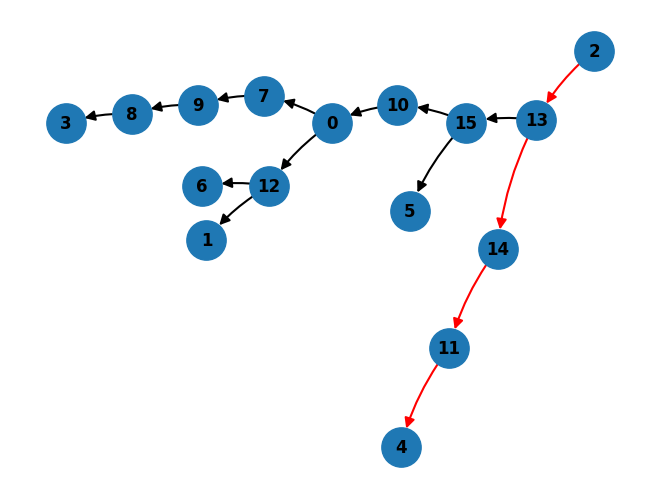

In [2]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [4]:
model_name="model.pt"

In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), model_name)

In [6]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


In [7]:
test_graph = generate_example(n_states, 5, order="random")
labels, test_cache = get_example_cache(test_graph, model, dataset)


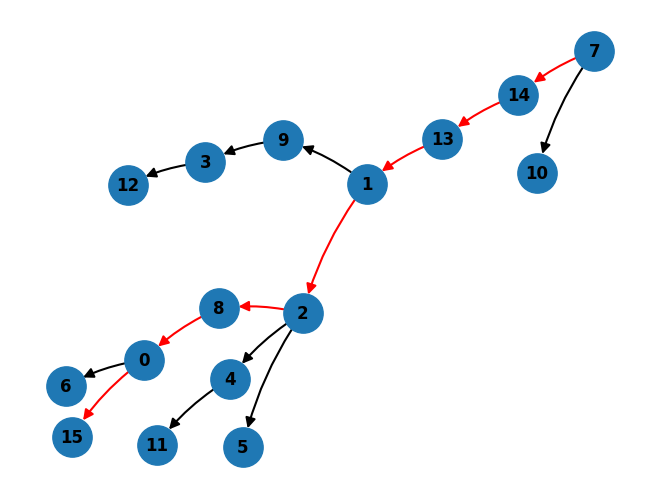

In [8]:
parse_example(test_graph)

In [9]:
labels, cache = get_example_cache(test_graph, model, dataset)

In [10]:
def ablation_hook(
            resid_pre,
            hook):
        # Each HookPoint has a name attribute giving the name of the hook.
        resid_pre = resid_pre*0
        return resid_pre

In [11]:
test_cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [12]:
def logit_lens_hook(pred, model,dataset, lenses=None):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.argmax(-1)
        lens_out = [dataset.idx2tokens[i] for i in out_proj]
        outs.append([f"Layer {layer} LL"] + lens_out[47:end])
    # Plot data
    header = dict(values=["Current Input"] + labels[47:end])
    rows = dict(values=np.array(outs).T.tolist())
    table = go.Table(header=header, cells=rows)
    layout = go.Layout(width=1000, height=700)
    figure = go.Figure(data=[table], layout=layout)
    figure.show()

In [13]:
def logit_lens_correct_probs_hook(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    probs = []
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
            out_proj = out_proj.softmax(-1)
        probs.append( out_proj[position, correct_token_idx].item() )
    # Plot data
    return probs, correct_token ,labels

In [14]:
test_graph = generate_example(n_states, 5, order="backward")

In [15]:
test_graph

'0>6,0>15,8>0,4>11,3>12,2>8,2>5,2>4,9>3,1>2,1>9,13>1,14>13,7>14,7>10|6:7>14>13>1>2>8>0>6'

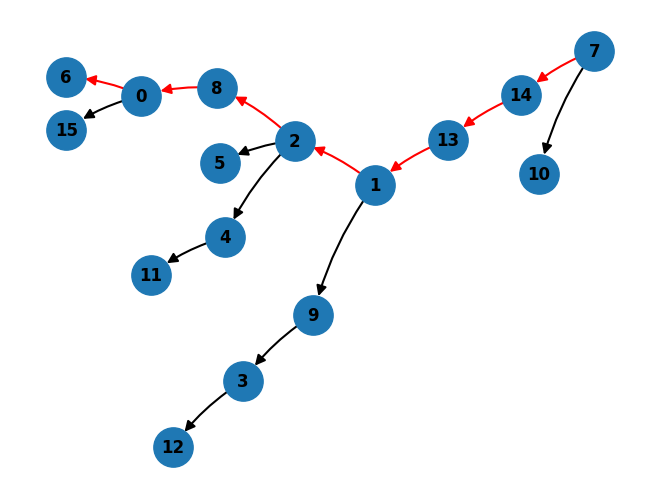

In [16]:
parse_example(test_graph)

In [17]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)

In [18]:
logit_lens_hook(test_graph,model,dataset, lenses=None)

In [19]:
probabilities=[]
for i in range(47,64):
    probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
    probabilities.append(probs)
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])


17
17


In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)

In [26]:
temp_hook_fn = ablation_hook
for layer in range(6):
    probabilities=[]
    for i in range(47,64):
        model.reset_hooks()
        model.blocks[layer].mlp.hook_post.add_hook(temp_hook_fn)
        probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
        probabilities.append(probs)
    print(f"layer{layer}")
    imshow(np.array(probabilities).T,x=labels[47:64])


layer0


layer1


layer2


layer3


layer4


layer5


In [ ]:
temp_hook_fn = ablation_hook
for layer in range(6):
    probabilities=[]
    for i in range(47,64):
        model.reset_hooks()
        model.blocks[layer].mlp.hook_post.add_hook(temp_hook_fn)
        probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
        probabilities.append(probs)
    print(f"layer{layer}")
    imshow(np.array(probabilities).T,x=labels[47:64])


### Test ablate mlp 0


In [ ]:
probabilities=[]
for i in range(47,64):
    probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
    probabilities.append(probs)
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])

### Tuned lens

In [20]:
lenses = calculate_tuned_lens(model, dataset)

0.5729898845798503
0.5916950060576318
0.6265738469059954
0.73811192002231
0.8459654552009234
0.9061186548174798


In [21]:
probabilities=[]
for i in range(47,64):
    probs, correct_token ,labels =logit_lens_correct_probs_hook(pred,model,dataset,i, lenses=lenses)
    probabilities.append(probs)
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])


17
17


In [22]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)

In [23]:
logit_lens_hook(pred, model)

TypeError: logit_lens_hook() missing 1 required positional argument: 'dataset'

In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward","backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1  
      #else:  
      #  parse_example(graph)
      #  plt.show()
      #  print(pred)
        
  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)

In [ ]:
model.reset_hooks()